# Tendencies along the filament

We define an axis that is along the direction of the filament and see if with respect to this, there are tendencies in velocity

This way, we see if there are for example different coherent structures in velocity, noticeable changes in sigma along the filament in the direction of SVS13, etc

Right now, we are only using the whole fit results (without QA and filtering) for HC3N and N2Hp. In particular this means **we will see outflows in the KDE**

In [1]:
import numpy as np
import os
from astropy.wcs import WCS
from astropy.io import fits
from scipy.stats import gaussian_kde
from astropy.coordinates import SkyCoord
import astropy.units as u
import sys
sys.path.append('/home/mvaldivi/velocity_tools')
from velocity_tools import coordinate_offsets
import matplotlib.pyplot as plt

In [2]:
# we want to compare both molecules so we do files for both
mol1 = 'N2Hp'
mol2 = 'HC3N'
mol1label = r'N$_2$H$^+$'
mol2label = r'HC$_3$N'
ncomp1 = 2
ncomp2 = 3

mlex1file_mol1 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x1_filtered_QA.fits'.format(mol1)
mlex2file_mol1 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x2_filtered_QA.fits'.format(mol1)
if ncomp1 == 3: mlex3file_mol1 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x3_filtered_QA.fits'.format(mol1)
ncompfilebayes_mol1 = '../bayes_frame/nested-sampling/{}/npeaks_cut5_noislands_QA.fits'.format(mol1)

mlex1file_mol2 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x1_filtered_QA.fits'.format(mol2)
mlex2file_mol2 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x2_filtered_QA.fits'.format(mol2)
if ncomp2 == 3: mlex3file_mol2 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x3_filtered_QA.fits'.format(mol2)
ncompfilebayes_mol2 = '../bayes_frame/nested-sampling/{}/npeaks_cut5_noislands_QA.fits'.format(mol2)

# for saving
kdevelfiledist_mol1 = '{}_kde_velocity_along_filament.npy'.format(mol1)
kdesigfiledist_mol1 = '{}_kde_sigma_along_filament.npy'.format(mol1)

kdevelfilecut_mol1 = '{}_kde_velocity_across_filament.npy'.format(mol1)
kdesigfilecut_mol1 = '{}_kde_sigma_across_filament.npy'.format(mol1)

kdevelfiledist_mol2 = '{}_kde_velocity_along_filament.npy'.format(mol2)
kdesigfiledist_mol2 = '{}_kde_sigma_along_filament.npy'.format(mol2)

kdevelfilecut_mol2 = '{}_kde_velocity_across_filament.npy'.format(mol2)
kdesigfilecut_mol2 = '{}_kde_sigma_across_filament.npy'.format(mol2)

# constants
distance = 298 * u.pc

In [3]:
# loading files

# molecule 1
mlex1_mol1 = fits.getdata(mlex1file_mol1)
mlex2_mol1 = fits.getdata(mlex2file_mol1)
if ncomp1 == 3: mlex3_mol1 = fits.getdata(mlex3file_mol1) 
ncomp_map_mol1 = fits.getdata(ncompfilebayes_mol1)
header_mol1 = fits.getheader(ncompfilebayes_mol1)
wcs1 = WCS(header_mol1)

xarray1 = np.linspace(0, header_mol1['NAXIS1']-1, header_mol1['NAXIS1'])
yarray1 = np.linspace(0, header_mol1['NAXIS2']-1, header_mol1['NAXIS2'])
XX1, YY1 = np.meshgrid(xarray1, yarray1)

pixsizearcsec1 = (header_mol1['CDELT2'] * u.deg).to(u.arcsec)

# molecule 2
mlex1_mol2 = fits.getdata(mlex1file_mol2)
mlex2_mol2 = fits.getdata(mlex2file_mol2)
if ncomp2 == 3: mlex3_mol2 = fits.getdata(mlex3file_mol2) 
ncomp_map_mol2 = fits.getdata(ncompfilebayes_mol2)
header_mol2 = fits.getheader(ncompfilebayes_mol2)
wcs2 = WCS(header_mol2)

xarray2 = np.linspace(0, header_mol2['NAXIS1']-1, header_mol2['NAXIS1'])
yarray2 = np.linspace(0, header_mol2['NAXIS2']-1, header_mol2['NAXIS2'])
XX2, YY2 = np.meshgrid(xarray2, yarray2)

pixsizearcsec2 = (header_mol2['CDELT2'] * u.deg).to(u.arcsec)

In [4]:
# quantities of interest
# molecule 1
vel1g_mol1 = mlex1_mol1[1] # velocity
vel2g1_mol1 = mlex2_mol1[1]
vel2g2_mol1 = mlex2_mol1[4]
if ncomp1 == 3: 
    vel3g1_mol1 = mlex3_mol1[1]
    vel3g2_mol1 = mlex3_mol1[4]
    vel3g3_mol1 = mlex3_mol1[7]
    velmaster_mol1 = np.array([vel1g_mol1, vel2g1_mol1, vel2g2_mol1, vel3g1_mol1, vel3g2_mol1, vel3g3_mol1])
else:
    velmaster_mol1 = np.array([vel1g_mol1, vel2g1_mol1, vel2g2_mol1])
    
sig1g_mol1 = mlex1_mol1[2] #velocity dispersion
sig2g1_mol1 = mlex2_mol1[2]
sig2g2_mol1 = mlex2_mol1[5]
if ncomp1 == 3: 
    sig3g1_mol1 = mlex3_mol1[2]
    sig3g2_mol1 = mlex3_mol1[5]
    sig3g3_mol1 = mlex3_mol1[8]
    sigmaster_mol1 = np.array([sig1g_mol1, sig2g1_mol1, sig2g2_mol1, sig3g1_mol1, sig3g2_mol1, sig3g3_mol1])
else:
    sigmaster_mol1 = np.array([sig1g_mol1, sig2g1_mol1, sig2g2_mol1])

# molecule 2
vel1g_mol2 = mlex1_mol2[1]
vel2g1_mol2 = mlex2_mol2[1]
vel2g2_mol2 = mlex2_mol2[4]
if ncomp2 == 3: 
    vel3g1_mol2 = mlex3_mol2[1]
    vel3g2_mol2 = mlex3_mol2[4]
    vel3g3_mol2 = mlex3_mol2[7]
    velmaster_mol2 = np.array([vel1g_mol2, vel2g1_mol2, vel2g2_mol2, vel3g1_mol2, vel3g2_mol2, vel3g3_mol2])
else:
    velmaster_mol2 = np.array([vel1g_mol2, vel2g1_mol2, vel2g2_mol2])
    
sig1g_mol2 = mlex1_mol2[2]
sig2g1_mol2 = mlex2_mol2[2]
sig2g2_mol2 = mlex2_mol2[5]
if ncomp2 == 3: 
    sig3g1_mol2 = mlex3_mol2[2]
    sig3g2_mol2 = mlex3_mol2[5]
    sig3g3_mol2 = mlex3_mol2[8]
    sigmaster_mol2 = np.array([sig1g_mol2, sig2g1_mol2, sig2g2_mol2, sig3g1_mol2, sig3g2_mol2, sig3g3_mol2])
else:
    sigmaster_mol2 = np.array([sig1g_mol2, sig2g1_mol2, sig2g2_mol2])


In [5]:
# building the map and the coordinate offsets with an angle
rotangle = (40 * u.deg).to(u.rad).value # degrees counterclockwise
XXprime1 = XX1 * np.cos(rotangle) - YY1 * np.sin(rotangle)
YYprime1 = XX1 * np.sin(rotangle) + YY1 * np.cos(rotangle)

XXprime2 = XX2 * np.cos(rotangle) - YY2 * np.sin(rotangle)
YYprime2 = XX2 * np.sin(rotangle) + YY2 * np.cos(rotangle)


Text(0.5, 1.0, 'Rotated Y value')

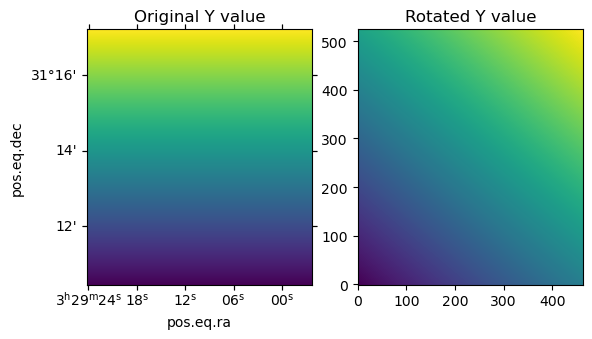

In [6]:
# This is just to check that the rotation was done in the expected angle
fig = plt.figure()
ax = fig.add_subplot(121, projection=wcs2)
ax.imshow(YY2, origin='lower')
ax.set_title('Original Y value')
ax2 = fig.add_subplot(122)
ax2.imshow(YYprime2, origin='lower')
ax2.set_title('Rotated Y value')
# ok all good

In [7]:
# y are the distance along the filament and x are across
# distarray are for along the filament, cutarray are for across
# molecule 1
mask_data_1g_mol1 = np.where(ncomp_map_mol1==1)
mask_data_2g_mol1 = np.where(ncomp_map_mol1==2)
if ncomp1 == 3: 
    mask_data_3g_mol1 = np.where(ncomp_map_mol1==3)
    velarray_mol1 = np.concatenate([vel1g_mol1[mask_data_1g_mol1], vel2g1_mol1[mask_data_2g_mol1], vel2g2_mol1[mask_data_2g_ml1], 
                                   vel3g1_mol1[mask_data_3g_mol1], vel3g2_mol1[mask_data_3g_mol1], vel3g2_mol1[mask_data_3g_mol1]])
    sigarray_mol1 = np.concatenate([sig1g_mol1[mask_data_1g_mol1], sig2g1_mol1[mask_data_2g_mol1], sig2g2_mol1[mask_data_2g_mol1], 
                                   sig3g1_mol1[mask_data_3g_mol1], sig3g2_mol1[mask_data_3g_mol1], sig3g2_mol1[mask_data_3g_mol1]])
    distarray_mol1 = np.concatenate([YYprime1[mask_data_1g_mol1], YYprime1[mask_data_2g_mol1], YYprime1[mask_data_2g_mol1],
                                     YYprime1[mask_data_3g_mol1], YYprime1[mask_data_3g_mol1], YYprime1[mask_data_3g_mol1]]) * pixsizearcsec1.value * distance.value 
    cutarray_mol1 = np.concatenate([XXprime1[mask_data_1g_mol1], XXprime1[mask_data_2g_mol1], XXprime1[mask_data_2g_mol1],
                                     XXprime1[mask_data_3g_mol1], XXprime1[mask_data_3g_mol1], XXprime1[mask_data_3g_mol1]]) * pixsizearcsec1.value * distance.value 

else:
    velarray_mol1 = np.concatenate([vel1g_mol1[mask_data_1g_mol1], vel2g1_mol1[mask_data_2g_mol1], vel2g2_mol1[mask_data_2g_mol1]]) 
    sigarray_mol1 = np.concatenate([sig1g_mol1[mask_data_1g_mol1], sig2g1_mol1[mask_data_2g_mol1], sig2g2_mol1[mask_data_2g_mol1]]) 
    distarray_mol1 = np.concatenate([YYprime1[mask_data_1g_mol1], YYprime1[mask_data_2g_mol1], YYprime1[mask_data_2g_mol1]]) * pixsizearcsec1.value * distance.value 
    cutarray_mol1 = np.concatenate([XXprime1[mask_data_1g_mol1], XXprime1[mask_data_2g_mol1], XXprime1[mask_data_2g_mol1]]) * pixsizearcsec1.value * distance.value 


# molecule 2
mask_data_1g_mol2 = np.where(ncomp_map_mol2==1)
mask_data_2g_mol2 = np.where(ncomp_map_mol2==2)
if ncomp2 == 3: 
    mask_data_3g_mol2 = np.where(ncomp_map_mol2==3)
    velarray_mol2 = np.concatenate([vel1g_mol2[mask_data_1g_mol2], vel2g1_mol2[mask_data_2g_mol2], vel2g2_mol2[mask_data_2g_mol2], 
                                   vel3g1_mol2[mask_data_3g_mol2], vel3g2_mol2[mask_data_3g_mol2], vel3g2_mol2[mask_data_3g_mol2]])
    sigarray_mol2 = np.concatenate([sig1g_mol2[mask_data_1g_mol2], sig2g1_mol2[mask_data_2g_mol2], sig2g2_mol2[mask_data_2g_mol2], 
                                   sig3g1_mol2[mask_data_3g_mol2], sig3g2_mol2[mask_data_3g_mol2], sig3g2_mol2[mask_data_3g_mol2]])
    distarray_mol2 = np.concatenate([YYprime2[mask_data_1g_mol2], YYprime2[mask_data_2g_mol2], YYprime2[mask_data_2g_mol2],
                                     YYprime2[mask_data_3g_mol2], YYprime2[mask_data_3g_mol2], YYprime2[mask_data_3g_mol2]]) * pixsizearcsec2.value * distance.value 
    cutarray_mol2 = np.concatenate([XXprime2[mask_data_1g_mol2], XXprime2[mask_data_2g_mol2], XXprime2[mask_data_2g_mol2],
                                     XXprime2[mask_data_3g_mol2], XXprime2[mask_data_3g_mol2], XXprime2[mask_data_3g_mol2]]) * pixsizearcsec2.value * distance.value 


else:
    velarray_mol2 = np.concatenate([vel1g_mol2[mask_data_1g_mol2], vel2g1_mol2[mask_data_2g_mol2], vel2g2_mol2[mask_data_2g_mol2]]) 
    sigarray_mol2 = np.concatenate([sig1g_mol2[mask_data_1g_mol2], sig2g1_mol2[mask_data_2g_mol2], sig2g2_mol2[mask_data_2g_mol2]]) 
    distarray_mol2 = np.concatenate([YYprime2[mask_data_1g_mol2], YYprime2[mask_data_2g_mol2], YYprime2[mask_data_2g_mol2]]) * pixsizearcsec2.value * distance.value 
    cutarray_mol2 = np.concatenate([XXprime2[mask_data_1g_mol2], XXprime2[mask_data_2g_mol2], XXprime2[mask_data_2g_mol2]]) * pixsizearcsec2.value * distance.value 


## Gradients along the filament

### Velocity

In [8]:
# here we build the space for the KDE to be plotted
xmin = 0
xmax = 160000
# y is velocity lsr
ymin = 6
ymax = 9

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

if not os.path.exists(kdevelfilecut_mol1):
    gd_vlos_mol1 = np.isfinite(velarray_mol1*distarray_mol1)
    values_mol1 = np.vstack([distarray_mol1[gd_vlos_mol1], velarray_mol1[gd_vlos_mol1]])
    kernel_mol1 = gaussian_kde(values_mol1)
    zz_mol1 = np.reshape(kernel_mol1(positions).T, xx.shape)
    zz_mol1 /= zz_mol1.max() 
    np.save(kdevelfiledist_mol1, zz_mol1)
else:
    zz_mol1 = np.load(kdevelfiledist_mol1)
    
if not os.path.exists(kdevelfiledist_mol2):
    gd_vlos_mol2 = np.isfinite(velarray_mol2*distarray_mol2)
    values_mol2 = np.vstack([distarray_mol2[gd_vlos_mol2], velarray_mol2[gd_vlos_mol2]])
    kernel_mol2 = gaussian_kde(values_mol2)
    zz_mol2 = np.reshape(kernel_mol2(positions).T, xx.shape)
    zz_mol2 /= zz_mol2.max() 
    np.save(kdevelfiledist_mol2, zz_mol2)
else:
    zz_mol2 = np.load(kdevelfiledist_mol2)

/tmp/ipykernel_13680/1549103691.py:3: UserWarning: The following kwargs were not used by contour: 'label'
  cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
/tmp/ipykernel_13680/1549103691.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)


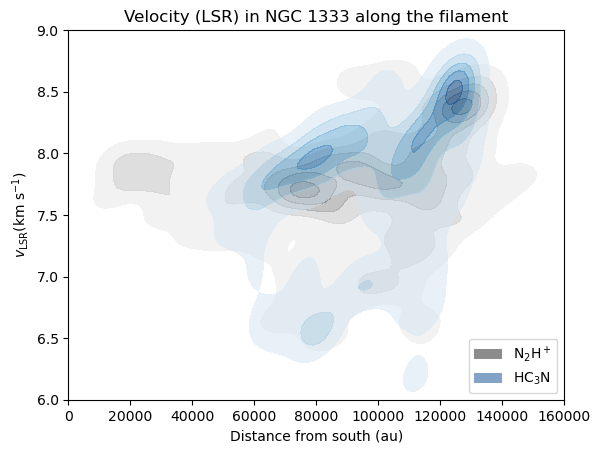

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
ax.set_ylim([ymin,ymax])
ax.set_xlim([xmin,xmax])
areas = [plt.Rectangle((1, 1), 2, 2, fc=cs1.collections[-1].get_facecolor()[0]), 
         plt.Rectangle((1, 1), 2, 2, fc=cs2.collections[-1].get_facecolor()[0])]
labels = [mol1label, mol2label]
ax.legend(areas, labels, loc='lower right')
ax.set_title('Velocity (LSR) in NGC 1333 along the filament')
ax.set_xlabel('Distance from south (au)')
ax.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')

fig.savefig('KDE_vlsr_along_filament.pdf', bbox_inches='tight')

Note here that a larger density of points is due to the thickness of the filament. Also, remember HC3N has less points but this shows only relative density, so it can still happen that the apparent difference is not significant.

### Velocity dispersion

In [10]:
# here we build the space for the KDE to be plotted
xmin = 0
xmax = 160000
# y is velocity dispersion
ymin = 0
ymax = 1.
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

if not os.path.exists(kdesigfiledist_mol1):
    gd_sig_mol1 = np.isfinite(sigarray_mol1*distarray_mol1)
    values_mol1 = np.vstack([distarray_mol1[gd_sig_mol1], sigarray_mol1[gd_sig_mol1]])
    kernel_mol1 = gaussian_kde(values_mol1)
    zz_mol1 = np.reshape(kernel_mol1(positions).T, xx.shape)
    zz_mol1 /= zz_mol1.max() 
    np.save(kdesigfiledist_mol1, zz_mol1)
else:
    zz_mol1 = np.load(kdesigfiledist_mol1)

if not os.path.exists(kdesigfiledist_mol2):
    gd_sig_mol2 = np.isfinite(sigarray_mol2*distarray_mol2)
    values_mol2 = np.vstack([distarray_mol2[gd_sig_mol2], sigarray_mol2[gd_sig_mol2]])
    kernel_mol2 = gaussian_kde(values_mol2)
    zz_mol2 = np.reshape(kernel_mol2(positions).T, xx.shape)
    zz_mol2 /= zz_mol2.max() 
    np.save(kdesigfiledist_mol2, zz_mol2)

else:
    zz_mol2 = np.load(kdesigfiledist_mol2)


/tmp/ipykernel_13680/503256365.py:3: UserWarning: The following kwargs were not used by contour: 'label'
  cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
/tmp/ipykernel_13680/503256365.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)


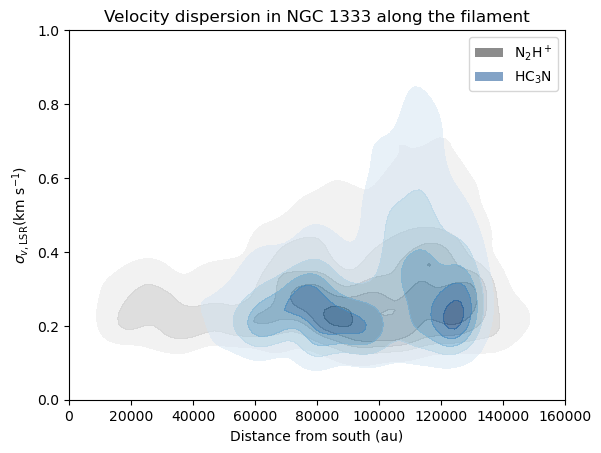

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
ax.set_ylim([ymin,ymax])
ax.set_xlim([xmin,xmax])
areas = [plt.Rectangle((1, 1), 2, 2, fc=cs1.collections[-1].get_facecolor()[0]), 
         plt.Rectangle((1, 1), 2, 2, fc=cs2.collections[-1].get_facecolor()[0])]
labels = [mol1label, mol2label]
ax.legend(areas, labels)

ax.set_xlabel('Distance from south (au)')
ax.set_ylabel(r'$\sigma_{v,\mathrm{LSR}}$(km s$^{-1}$)')
ax.set_title('Velocity dispersion in NGC 1333 along the filament')
fig.savefig('KDE_sig_along_filament.pdf', bbox_inches='tight')

In [12]:
# now we could do some clustering to determine which points are part of which layers


# also test the kde for sigma
# also put HC3N


## Gradients accross the filament

### Velocity

In [13]:
# here we build the space for the KDE to be plotted
xmin = -40000
xmax = 40000
# y is velocity lsr
ymin = 6
ymax = 9

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

if not os.path.exists(kdevelfilecut_mol1):
    gcut_vlos_mol1 = np.isfinite(velarray_mol1*cutarray_mol1)
    values_across_mol1 = np.vstack([cutarray_mol1[gcut_vlos_mol1], velarray_mol1[gcut_vlos_mol1]])
    kernel_mol1 = gaussian_kde(values_across_mol1)
    zz_mol1 = np.reshape(kernel_mol1(positions).T, xx.shape)
    zz_mol1 /= zz_mol1.max() 
    np.save(kdevelfilecut_mol1, zz_mol1)
else:
    zz_mol1 = np.load(kdevelfilecut_mol1)

if not os.path.exists(kdevelfilecut_mol2):
    gcut_vlos_mol2 = np.isfinite(velarray_mol2*cutarray_mol2)
    values_across_mol2 = np.vstack([cutarray_mol2[gcut_vlos_mol2], velarray_mol2[gcut_vlos_mol2]])
    kernel_mol2 = gaussian_kde(values_across_mol2)
    zz_mol2 = np.reshape(kernel_mol2(positions).T, xx.shape)
    zz_mol2 /= zz_mol2.max() 
    np.save(kdevelfilecut_mol2, zz_mol2)
else:
    zz_mol2 = np.load(kdevelfilecut_mol2)

/tmp/ipykernel_13680/3954739887.py:3: UserWarning: The following kwargs were not used by contour: 'label'
  cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
/tmp/ipykernel_13680/3954739887.py:4: UserWarning: The following kwargs were not used by contour: 'label'
  cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)


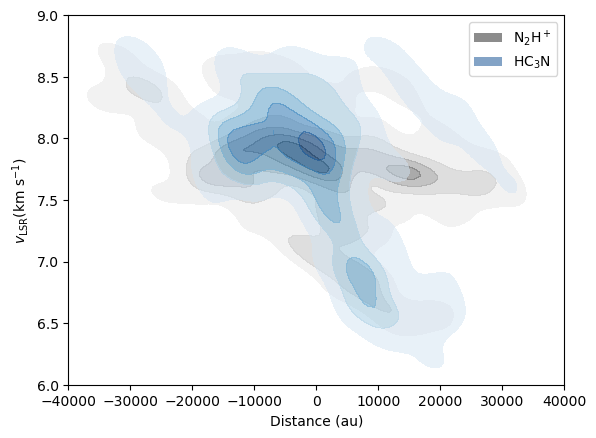

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)
ax.set_ylim([ymin,ymax])
ax.set_xlim([xmin,xmax])
areas = [plt.Rectangle((1, 1), 2, 2, fc=cs1.collections[-1].get_facecolor()[0]), 
         plt.Rectangle((1, 1), 2, 2, fc=cs2.collections[-1].get_facecolor()[0])]
labels = [mol1label, mol2label]
ax.legend(areas, labels)

ax.set_xlabel('Distance (au)')
ax.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')

fig.savefig('KDE_vlsr_across_filament.pdf', bbox_inches='tight')

### Velocity dispersion

In [15]:
# here we build the space for the KDE to be plotted
xmin = -40000
xmax = 40000
# y is velocity dispersion
ymin = 0
ymax = 1
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

if not os.path.exists(kdesigfilecut_mol1):
    gcut_sig_mol1 = np.isfinite(sigarray_mol1*cutarray_mol1)
    values_mol1 = np.vstack([cutarray_mol1[gcut_sig_mol1], sigarray_mol1[gcut_sig_mol1]])
    kernel_mol1 = gaussian_kde(values_mol1)
    zz_mol1 = np.reshape(kernel_mol1(positions).T, xx.shape)
    zz_mol1 /= zz_mol1.max() 
    np.save(kdesigfilecut_mol1, zz_mol1)
else:
    zz_mol1 = np.load(kdesigfilecut_mol1)

if not os.path.exists(kdesigfilecut_mol2):
    gcut_sig_mol2 = np.isfinite(sigarray_mol2*cutarray_mol2)
    values_mol2 = np.vstack([cutarray_mol2[gcut_sig_mol2], sigarray_mol2[gcut_sig_mol2]])
    kernel_mol2 = gaussian_kde(values_mol2)
    zz_mol2 = np.reshape(kernel_mol2(positions).T, xx.shape)
    zz_mol2 /= zz_mol2.max() 
    np.save(kdesigfilecut_mol2, zz_mol2)

else:
    zz_mol2 = np.load(kdesigfilecut_mol2)


/tmp/ipykernel_13680/2910071297.py:3: UserWarning: The following kwargs were not used by contour: 'label'
  cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
/tmp/ipykernel_13680/2910071297.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)


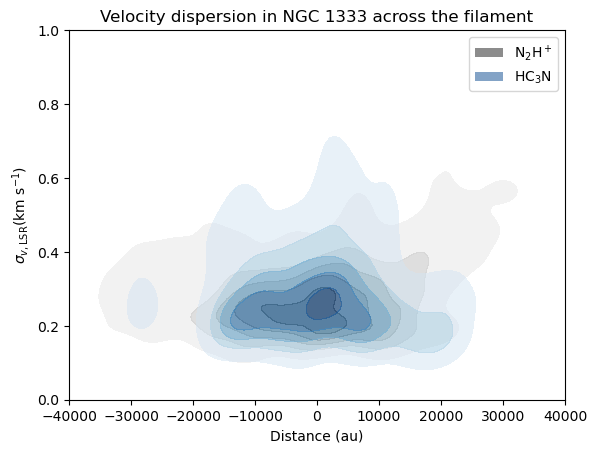

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
ax.set_ylim([ymin,ymax])
ax.set_xlim([xmin,xmax])
areas = [plt.Rectangle((1, 1), 2, 2, fc=cs1.collections[-1].get_facecolor()[0]), 
         plt.Rectangle((1, 1), 2, 2, fc=cs2.collections[-1].get_facecolor()[0])]
labels = [mol1label, mol2label]
ax.legend(areas, labels)
ax.set_title('Velocity dispersion in NGC 1333 across the filament')

ax.set_xlabel('Distance (au)')
ax.set_ylabel(r'$\sigma_{v,\mathrm{LSR}}$(km s$^{-1}$)')
fig.savefig('KDE_sig_across_filament.pdf', bbox_inches='tight')

## Tendencies along and across the independant fibers

In [34]:
clusters_red_fileHC3N = '../clustering/clusters_red_HC3N.fits'
clusters_blue_fileHC3N = '../clustering/clusters_blue_HC3N.fits'
clusters_red_fileN2Hp = '../clustering/clusters_red_N2Hp.fits'
clusters_blue_fileN2Hp = '../clustering/clusters_blue_N2Hp.fits'

clusters_redHC3N, clusters_headHC3N = fits.getdata(clusters_red_fileHC3N, header=True)
clusters_blueHC3N = fits.getdata(clusters_blue_fileHC3N)
clusters_redN2Hp, clusters_headN2Hp = fits.getdata(clusters_red_fileN2Hp, header=True)
clusters_blueN2Hp = fits.getdata(clusters_blue_fileN2Hp)


pixsizearcsecHC3N = clusters_headHC3N['cdelt2'] * 3600 * u.arcsec
pixsizearcsecN2Hp = clusters_headN2Hp['cdelt2'] * 3600 * u.arcsec


# YYprime1 are the pixel distnces from south to north
YYprimeHC3N_arcsec = YYprime2 * pixsizearcsecHC3N # this leaves it in arcsec
XXprimeHC3N_arcsec = XXprime2 * pixsizearcsecHC3N # this leaves it in arcsec
YYprimeN2Hp_arcsec = YYprime1 * pixsizearcsecN2Hp # this leaves it in arcsec
XXprimeN2Hp_arcsec = XXprime1 * pixsizearcsecN2Hp # this leaves it in arcsec

YYprimeHC3N = YYprime2
XXprimeHC3N = XXprime2 
YYprimeN2Hp = YYprime1
XXprimeN2Hp = XXprime1

In [18]:
mask_redHC3N = np.where(~np.isnan(clusters_redHC3N[0]), 1, np.nan)
mask_blueHC3N = np.where(~np.isnan(clusters_blueHC3N[0]), 1, np.nan)

### Test: do a curve of velocities with cuts across the fiber every beam

In [19]:
# select all pixels that have a Y' value between certain values
# lets test first with 250 arcsec from south
# it worked, lets through it all
beammajHC3N = (clusters_headHC3N['bmaj']*u.deg).to(u.arcsec)
yymin, yymax = np.nanmin(mask_redHC3N * YYprimeHC3N_arcsec), np.nanmax(mask_redHC3N * YYprimeHC3N_arcsec)
nbeamsfiber = ((yymax - yymin)/beammajHC3N).value.astype(int)
yyarray = np.linspace(yymin+ beammajHC3N/2, yymax- beammajHC3N/2, nbeamsfiber)
xxarray_master =  []
velarray_master = []

In [20]:
yymin, yymax

(<Quantity 58.26533362 arcsec>, <Quantity 449.20109497 arcsec>)

In [21]:
for j in range(len(yyarray)):
    yyminprime = yyarray[j] - beammajHC3N/2
    yymaxprime = yyarray[j] + beammajHC3N/2

    velareamask = np.where(YYprimeHC3N_arcsec<yymaxprime, 1, np.nan) * np.where(YYprimeHC3N_arcsec>yyminprime, 1, np.nan)
    velarea = velareamask * clusters_redHC3N[1]
    velareaunc = velareamask * clusters_redHC3N[4]
    XXprimearea = XXprimeHC3N_arcsec * velareamask * mask_redHC3N

    xxmin, xxmax = np.nanmin(XXprimearea), np.nanmax(XXprimearea)
    nbeams = ((xxmax - xxmin)/beammajHC3N).value.astype(int)
    xxarray = np.linspace(xxmin+ beammajHC3N/2, xxmax- beammajHC3N/2, nbeams)
    xxarray_master.append(xxarray)
    velarray = np.zeros(np.shape(xxarray)) * np.nan

    for i in range(len(xxarray)):
        xxminprime = xxarray[i] - beammajHC3N/2 
        xxmaxprime = xxarray[i] + beammajHC3N/2
        velarraymask = np.where(XXprimearea<xxmaxprime, 1, np.nan)*np.where(XXprimearea>xxminprime, 1, np.nan)
        velarray[i] = np.nanmean(velarraymask * velarea)
    velarray_master.append(velarray)

/tmp/ipykernel_13680/728921939.py:20: RuntimeWarning: Mean of empty slice
  velarray[i] = np.nanmean(velarraymask * velarea)


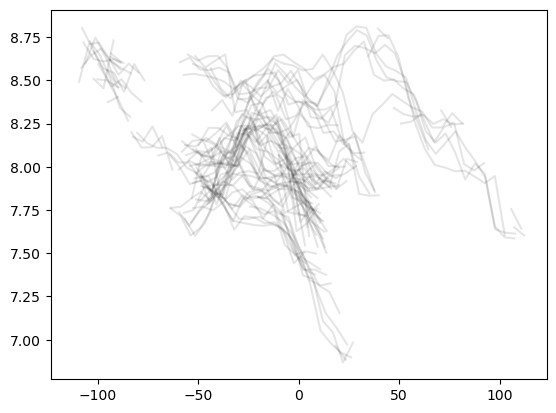

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
for j in range(len(xxarray_master)):
    ax.plot(xxarray_master[j], velarray_master[j], color='k', alpha=0.1)

### KDE of each fiber

In [23]:
# now we do the KDE of each fiber
velarray_redfiberhc3n = clusters_redHC3N[1]
velarray_bluefiberhc3n = clusters_blueHC3N[1]
velarray_redfibern2hp = clusters_redN2Hp[1]
velarray_bluefibern2hp = clusters_blueN2Hp[1]

intarray_redfiberhc3n = clusters_redHC3N[0]
intarray_bluefiberhc3n = clusters_blueHC3N[0]
intarray_redfibern2hp = clusters_redN2Hp[0]
intarray_bluefibern2hp = clusters_blueN2Hp[0]

kdefile_redHC3N_across = 'KDE_red_HC3N_across.npy'
kdefile_blueHC3N_across = 'KDE_blue_HC3N_across.npy'
kdefile_redHC3N_along = 'KDE_red_HC3N_along.npy'
kdefile_blueHC3N_along = 'KDE_blue_HC3N_along.npy'

kdefile_redN2Hp_across = 'KDE_red_N2Hp_across.npy'
kdefile_blueN2Hp_across = 'KDE_blue_N2Hp_across.npy'
kdefile_redN2Hp_along = 'KDE_red_N2Hp_along.npy'
kdefile_blueN2Hp_along = 'KDE_blue_N2Hp_along.npy'

Text(0, 0.5, '$v_{\\mathrm{LSR}}$(km s$^{-1}$)')

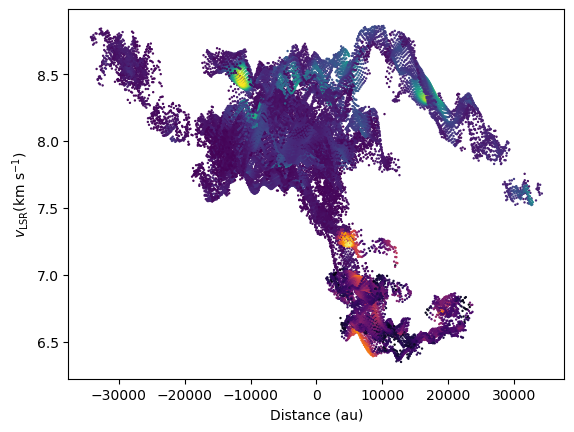

In [24]:
gcut_vlos_redHC3N = np.isfinite(velarray_redfiberhc3n*XXprimeHC3N_arcsec)
gcut_vlos_blueHC3N = np.isfinite(velarray_bluefiberhc3n*XXprimeHC3N_arcsec)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(XXprimeHC3N_arcsec.value[gcut_vlos_redHC3N] * distance.value, 
           velarray_redfiberhc3n[gcut_vlos_redHC3N], s=0.5,
           c=intarray_redfiberhc3n[gcut_vlos_redHC3N])
ax.scatter(XXprimeHC3N_arcsec.value[gcut_vlos_blueHC3N] * distance.value, 
           velarray_bluefiberhc3n[gcut_vlos_blueHC3N], s=0.5,
           c=intarray_bluefiberhc3n[gcut_vlos_blueHC3N], cmap='inferno')

ax.set_xlabel('Distance (au)')
ax.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')

Text(0, 0.5, '$v_{\\mathrm{LSR}}$(km s$^{-1}$)')

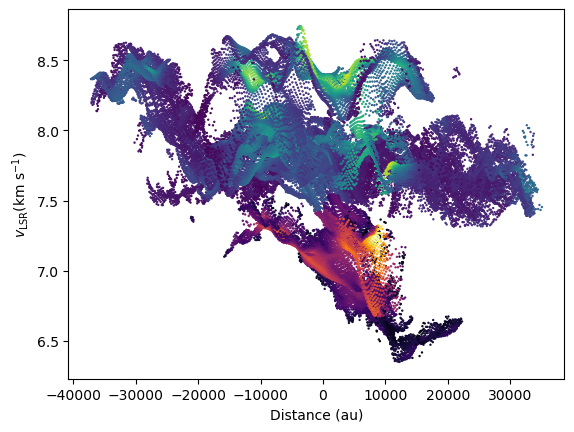

In [25]:
gcut_vlos_redN2Hp = np.isfinite(velarray_redfibern2hp*XXprimeN2Hp_arcsec)
gcut_vlos_blueN2Hp = np.isfinite(velarray_bluefibern2hp*XXprimeN2Hp_arcsec)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(XXprimeN2Hp_arcsec.value[gcut_vlos_redN2Hp] * distance.value, 
           velarray_redfibern2hp[gcut_vlos_redN2Hp], s=0.5,
           c=intarray_redfibern2hp[gcut_vlos_redN2Hp])
ax.scatter(XXprimeN2Hp_arcsec.value[gcut_vlos_blueN2Hp] * distance.value, 
           velarray_bluefibern2hp[gcut_vlos_blueN2Hp], s=0.5,
           c=intarray_bluefibern2hp[gcut_vlos_blueN2Hp], cmap='inferno')

ax.set_xlabel('Distance (au)')
ax.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')

Text(0, 0.5, '$v_{\\mathrm{LSR}}$(km s$^{-1}$)')

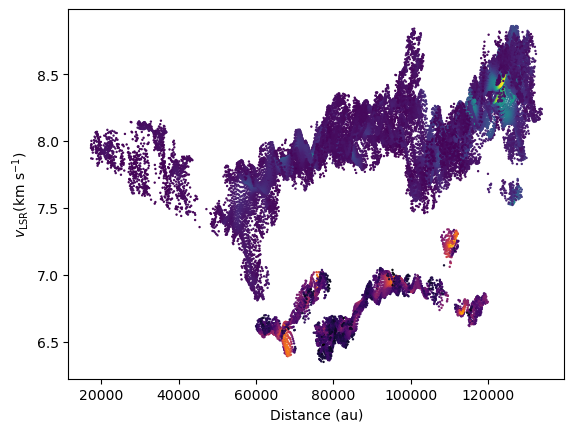

In [26]:
gcut_vlos_redHC3N = np.isfinite(velarray_redfiberhc3n*YYprimeHC3N_arcsec)
gcut_vlos_blueHC3N = np.isfinite(velarray_bluefiberhc3n*YYprimeHC3N_arcsec)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(YYprimeHC3N_arcsec.value[gcut_vlos_redHC3N] * distance.value, 
           velarray_redfiberhc3n[gcut_vlos_redHC3N], s=0.5,
           c=intarray_redfiberhc3n[gcut_vlos_redHC3N])
ax.scatter(YYprimeHC3N_arcsec.value[gcut_vlos_blueHC3N] * distance.value, 
           velarray_bluefiberhc3n[gcut_vlos_blueHC3N], s=0.5,
           c=intarray_bluefiberhc3n[gcut_vlos_blueHC3N], cmap='inferno')

ax.set_xlabel('Distance (au)')
ax.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')

In [27]:
rotangle

0.6981317007977318

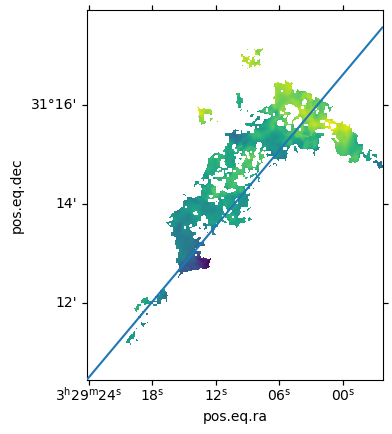

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs2)
ax.imshow(velarray_redfiberhc3n)
ax.plot(xarray2, xarray2*np.tan((50*u.deg).to(u.rad).value))

### KDE across each fiber


In [39]:
YYprimeHC3N

array([[0.00000000e+00, 6.42787610e-01, 1.28557522e+00, ...,
        2.96325088e+02, 2.96967876e+02, 2.97610663e+02],
       [7.66044443e-01, 1.40883205e+00, 2.05161966e+00, ...,
        2.97091133e+02, 2.97733920e+02, 2.98376708e+02],
       [1.53208889e+00, 2.17487650e+00, 2.81766411e+00, ...,
        2.97857177e+02, 2.98499965e+02, 2.99142752e+02],
       ...,
       [3.99875199e+02, 4.00517987e+02, 4.01160775e+02, ...,
        6.96200287e+02, 6.96843075e+02, 6.97485863e+02],
       [4.00641244e+02, 4.01284031e+02, 4.01926819e+02, ...,
        6.96966332e+02, 6.97609119e+02, 6.98251907e+02],
       [4.01407288e+02, 4.02050076e+02, 4.02692863e+02, ...,
        6.97732376e+02, 6.98375164e+02, 6.99017951e+02]])

In [40]:

# here we build the space for the KDE to be plotted
xmin = -200
xmax = 200
# y is velocity lsr
ymin = 6
ymax = 9

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

if not os.path.exists(kdefile_redHC3N_across):
    gcut_vlos_redHC3N = np.isfinite(velarray_redfiberhc3n*XXprimeHC3N)
    values_across_redHC3N = np.vstack([XXprimeHC3N[gcut_vlos_redHC3N], velarray_redfiberhc3n[gcut_vlos_redHC3N]])
    kernel_redHC3N = gaussian_kde(values_across_redHC3N)
    zz_redHC3N = np.reshape(kernel_redHC3N(positions).T, xx.shape)
    zz_redHC3N /= zz_redHC3N.max() 
    np.save(kdefile_redHC3N_across, zz_redHC3N)
else:
    zz_redHC3N = np.load(kdefile_redHC3N_across)


if not os.path.exists(kdefile_blueHC3N_across):
    gcut_vlos_blueHC3N = np.isfinite(velarray_bluefiberhc3n*XXprimeHC3N)
    values_across_blueHC3N = np.vstack([XXprimeHC3N[gcut_vlos_blueHC3N], velarray_bluefiberhc3n[gcut_vlos_blueHC3N]])
    kernel_blueHC3N = gaussian_kde(values_across_blueHC3N)
    zz_blueHC3N = np.reshape(kernel_blueHC3N(positions).T, xx.shape)
    zz_blueHC3N /= zz_blueHC3N.max() 
    np.save(kdefile_blueHC3N_across, zz_blueHC3N)
else:
    zz_blueHC3N = np.load(kdefile_blueHC3N_across)


    
if not os.path.exists(kdefile_redN2Hp_across):
    gcut_vlos_redN2Hp = np.isfinite(velarray_redfibern2hp*XXprimeN2Hp)
    values_across_redN2Hp = np.vstack([XXprimeN2Hp[gcut_vlos_redN2Hp], velarray_redfibern2hp[gcut_vlos_redN2Hp]])
    kernel_redN2Hp = gaussian_kde(values_across_redN2Hp)
    zz_redN2Hp = np.reshape(kernel_redN2Hp(positions).T, xx.shape)
    zz_redN2Hp /= zz_redN2Hp.max() 
    np.save(kdefile_redN2Hp_across, zz_redN2Hp)
else:
    zz_redN2Hp = np.load(kdefile_redN2Hp_across)


if not os.path.exists(kdefile_blueN2Hp_across):
    gcut_vlos_blueN2Hp = np.isfinite(velarray_bluefibern2hp*XXprimeN2Hp)
    values_across_blueN2Hp = np.vstack([XXprimeN2Hp[gcut_vlos_blueN2Hp], velarray_bluefibern2hp[gcut_vlos_blueN2Hp]])
    kernel_blueN2Hp = gaussian_kde(values_across_blueN2Hp)
    zz_blueN2Hp = np.reshape(kernel_blueN2Hp(positions).T, xx.shape)
    zz_blueN2Hp /= zz_blueN2Hp.max() 
    np.save(kdefile_blueN2Hp_across, zz_blueN2Hp)
else:
    zz_blueN2Hp = np.load(kdefile_blueN2Hp_across)



Text(0.5, 1.0, 'Velocity across the fibers n2hp')

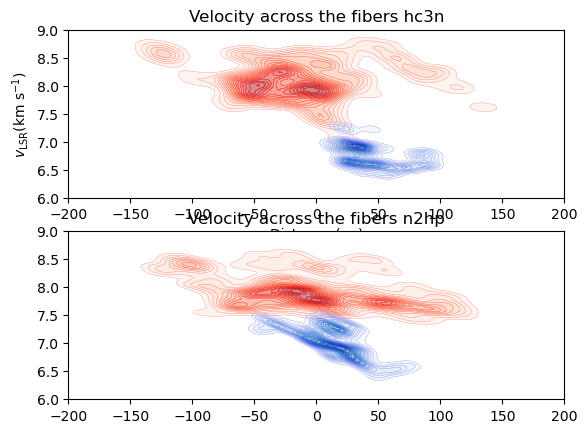

In [41]:
fig = plt.figure()
ax = fig.add_subplot(211)
cs1 = ax.contourf(xx, yy, zz_redHC3N, cmap='Reds', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, alpha=0.5)
ax.contour(xx, yy, zz_redHC3N, colors='r', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, linewidths=0.1)
cs2 = ax.contourf(xx, yy, zz_blueHC3N, cmap='Blues', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1,alpha=0.5)
ax.contour(xx, yy, zz_blueHC3N, colors='b', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, linewidths=0.1)
# ax.axhline(v_lsr.value, color='k')
# ax.axhline(v_lsr.value, color='k')
ax.set_ylim([ymin,ymax])
ax.set_xlim([xmin,xmax])
ax.set_title('Velocity across the fibers hc3n')

ax.set_xlabel('Distance (au)')
ax.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')
# fig.savefig('KDE_sig_across_filament.pdf', bbox_inches='tight')

ax2 = fig.add_subplot(212)
cs1 = ax2.contourf(xx, yy, zz_redN2Hp, cmap='Reds', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, alpha=0.5)
ax2.contour(xx, yy, zz_redN2Hp, colors='r', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, linewidths=0.1)
cs2 = ax2.contourf(xx, yy, zz_blueN2Hp, cmap='Blues', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1,alpha=0.5)
ax2.contour(xx, yy, zz_blueN2Hp, colors='b', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, linewidths=0.1)
ax2.set_title('Velocity across the fibers n2hp')

### KDE along each fiber

In [42]:

# here we build the space for the KDE to be plotted
xmin = 0
xmax = 600
# y is velocity lsr
ymin = 6
ymax = 9

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

if not os.path.exists(kdefile_redHC3N_along):
    gcut_vlos_redHC3N = np.isfinite(velarray_redfiberhc3n*YYprimeHC3N)
    values_along_redHC3N = np.vstack([YYprimeHC3N[gcut_vlos_redHC3N], velarray_redfiberhc3n[gcut_vlos_redHC3N]])
    kernel_redHC3N = gaussian_kde(values_along_redHC3N)
    zz_redHC3N = np.reshape(kernel_redHC3N(positions).T, xx.shape)
    zz_redHC3N /= zz_redHC3N.max() 
    np.save(kdefile_redHC3N_along, zz_redHC3N)
else:
    zz_redHC3N = np.load(kdefile_redHC3N_along)


if not os.path.exists(kdefile_blueHC3N_along):
    gcut_vlos_blueHC3N = np.isfinite(velarray_bluefiberhc3n*YYprimeHC3N)
    values_along_blueHC3N = np.vstack([YYprimeHC3N[gcut_vlos_blueHC3N], velarray_bluefiberhc3n[gcut_vlos_blueHC3N]])
    kernel_blueHC3N = gaussian_kde(values_along_blueHC3N)
    zz_blueHC3N = np.reshape(kernel_blueHC3N(positions).T, xx.shape)
    zz_blueHC3N /= zz_blueHC3N.max() 
    np.save(kdefile_blueHC3N_along, zz_blueHC3N)
else:
    zz_blueHC3N = np.load(kdefile_blueHC3N_along)


    
if not os.path.exists(kdefile_redN2Hp_along):
    gcut_vlos_redN2Hp = np.isfinite(velarray_redfibern2hp*YYprimeN2Hp)
    values_along_redN2Hp = np.vstack([YYprimeN2Hp[gcut_vlos_redN2Hp], velarray_redfibern2hp[gcut_vlos_redN2Hp]])
    kernel_redN2Hp = gaussian_kde(values_along_redN2Hp)
    zz_redN2Hp = np.reshape(kernel_redN2Hp(positions).T, xx.shape)
    zz_redN2Hp /= zz_redN2Hp.max() 
    np.save(kdefile_redN2Hp_along, zz_redN2Hp)
else:
    zz_redN2Hp = np.load(kdefile_redN2Hp_along)


if not os.path.exists(kdefile_blueN2Hp_along):
    gcut_vlos_blueN2Hp = np.isfinite(velarray_bluefibern2hp*YYprimeN2Hp)
    values_along_blueN2Hp = np.vstack([YYprimeN2Hp[gcut_vlos_blueN2Hp], velarray_bluefibern2hp[gcut_vlos_blueN2Hp]])
    kernel_blueN2Hp = gaussian_kde(values_along_blueN2Hp)
    zz_blueN2Hp = np.reshape(kernel_blueN2Hp(positions).T, xx.shape)
    zz_blueN2Hp /= zz_blueN2Hp.max() 
    np.save(kdefile_blueN2Hp_along, zz_blueN2Hp)
else:
    zz_blueN2Hp = np.load(kdefile_blueN2Hp_along)


Text(0, 0.5, '$v_{\\mathrm{LSR}}$(km s$^{-1}$)')

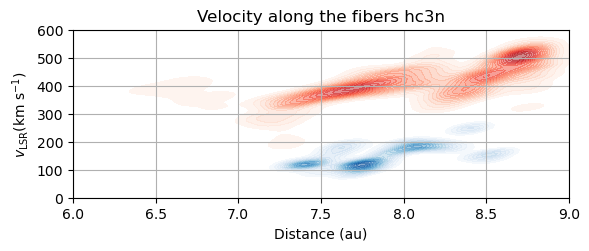

In [46]:
fig = plt.figure()
ax = fig.add_subplot(211)
cs1 = ax.contourf(yy, xx, zz_redHC3N.T, cmap='Reds', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, alpha=0.5)
# ax.contour(xx, yy, zz_redHC3N, colors='r', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, linewidths=0.1)
cs2 = ax.contourf(yy, xx, zz_blueHC3N.T, cmap='Blues', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1,alpha=0.5)
# ax.contour(xx, yy, zz_blueHC3N, colors='b', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, linewidths=0.1)
# ax.axhline(v_lsr.value, color='k')
# ax.axhline(v_lsr.value, color='k')
# ax.set_ylim([ymin,ymax])
# ax.set_xlim([xmin,xmax])
ax.set_title('Velocity along the fibers hc3n')
ax.grid(True)
ax.set_xlabel('Distance (au)')
ax.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')
# fig.savefig('KDE_sig_across_filament.pdf', bbox_inches='tight')

# ax2 = fig.add_subplot(212)

# cs1 = ax2.contourf(xx, yy, zz_redN2Hp, cmap='Reds', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, alpha=0.5)
# ax2.contour(xx, yy, zz_redN2Hp, colors='r', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, linewidths=0.1)
# cs2 = ax2.contourf(xx, yy, zz_blueN2Hp, cmap='Blues', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1,alpha=0.5)
# ax2.contour(xx, yy, zz_blueN2Hp, colors='b', levels=np.arange(0.05, 1.2, 0.05), vmin=0., vmax=1.1, linewidths=0.1)
# ax2.set_title('Velocity along the fibers n2hp')
# ax2.grid(True)